In [1]:
from typing import List,Union
import gradio as gr
from gradio.themes.utils import colors, fonts, sizes
import numpy as np
import torch
from torch.utils.data import DataLoader
import argparse
import cv2
import re
import pickle
import os
import copy
import time
import random
from PIL import Image
from transformers import AutoModelForCausalLM


In [ ]:
# read attention dict

with open("/code/okapi-mllm/data/freeze_self_attn.pkl",'rb') as f:
    freeze_projector_attn = pickle.load(f)
    f.close()


with open("/code/okapi-mllm/data/unfreeze.pkl",'rb') as f2:
    unfreeze_attn = pickle.load(f2)
    f.close()

In [3]:
llm_attn_matrix_freeze_mean = freeze_projector_attn['attention_mean']
llm_attn_matrix_unfreeze_mean = unfreeze_attn['attention_mean']

In [4]:
decode_labels = freeze_projector_attn['decode_labels']
ref_indices = freeze_projector_attn['ref_indices']
ref_indices_shift = ref_indices - 1
ref_indices = ref_indices.tolist()
ref_indices_shift = ref_indices_shift.tolist()

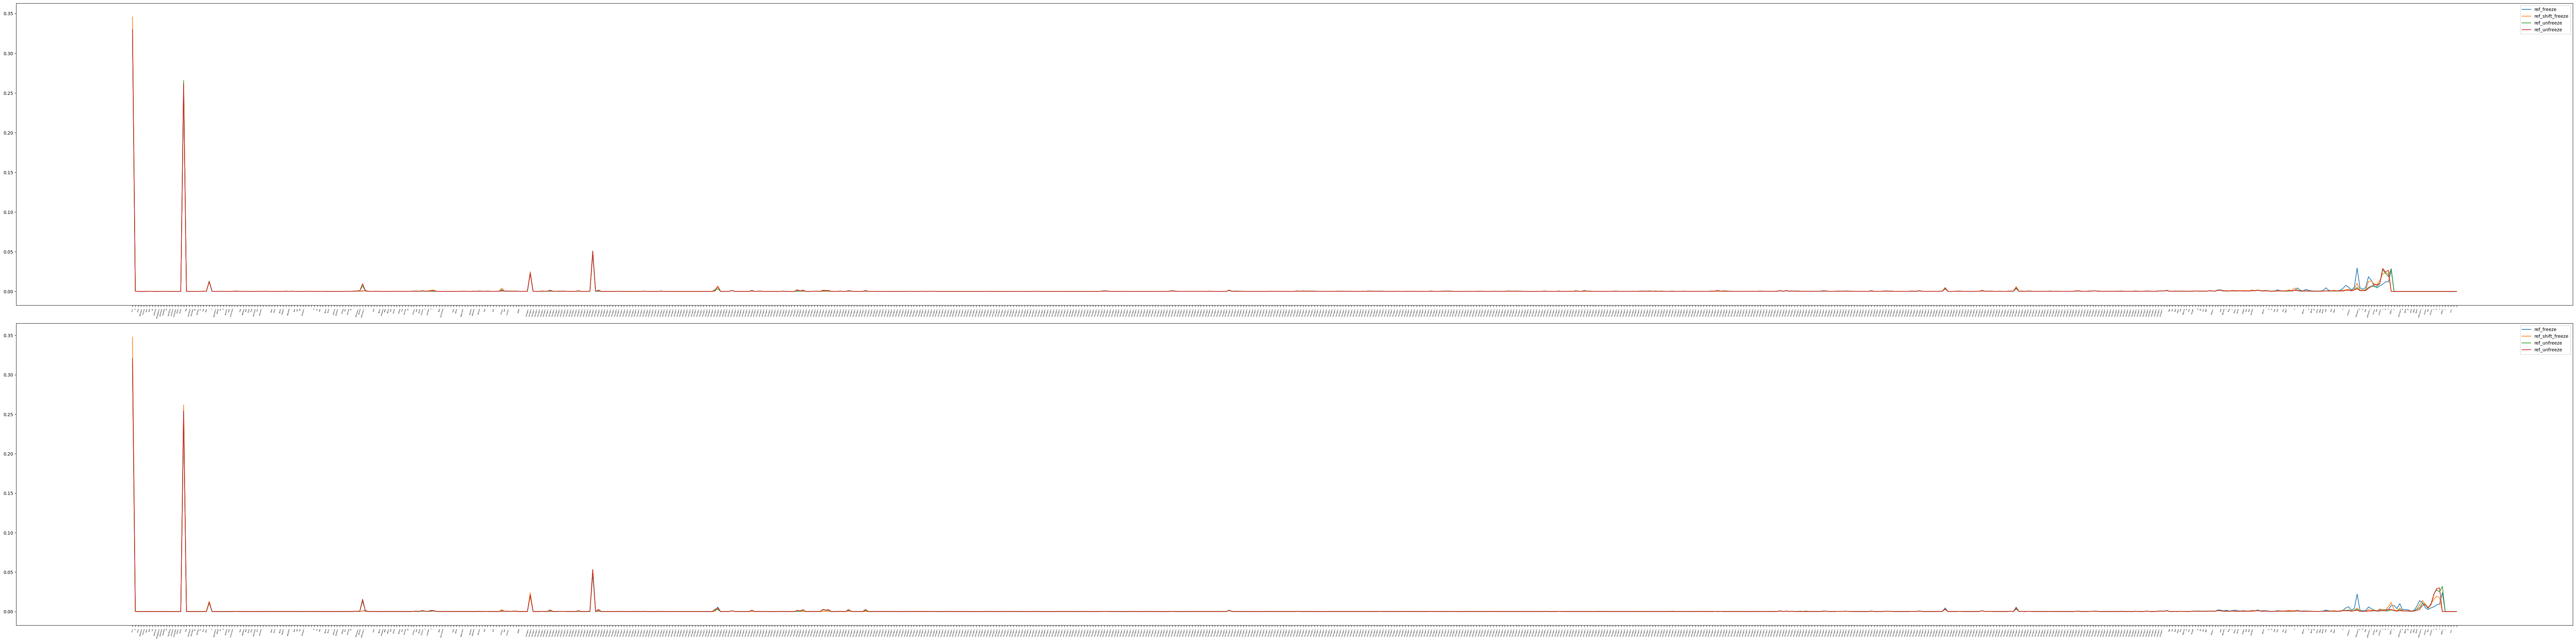

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(ref_indices),1,figsize=(80, 20))

for i,ref_index in enumerate(ref_indices):
    ref_attn_matrix = llm_attn_matrix_freeze_mean[ref_index,:]
    ref_attn_matrix_shift = llm_attn_matrix_freeze_mean[ref_indices_shift[i],:]
    ref_attn_matrix_unfreeze = llm_attn_matrix_unfreeze_mean[ref_index,:]
    ref_attn_matrix_unfreeze_shift = llm_attn_matrix_unfreeze_mean[ref_indices_shift[i],:]


    ax[i].plot(ref_attn_matrix,label='ref_freeze')
    ax[i].plot(ref_attn_matrix_shift,label='ref_shift_freeze')
    ax[i].plot(ref_attn_matrix_unfreeze,label='ref_unfreeze')
    ax[i].plot(ref_attn_matrix_unfreeze_shift,label='ref_unfreeze')
    ax[i].set_xticks(range(len(ref_attn_matrix)))
    ax[i].legend()
    ax[i].set_xticklabels(decode_labels,rotation=75, fontsize=4)
    # ax[i].set_title("at each token, the sum of attention weights over all the vision tokens")
    
# 显示图像
plt.tight_layout()
plt.show()

## Show the influence of image token

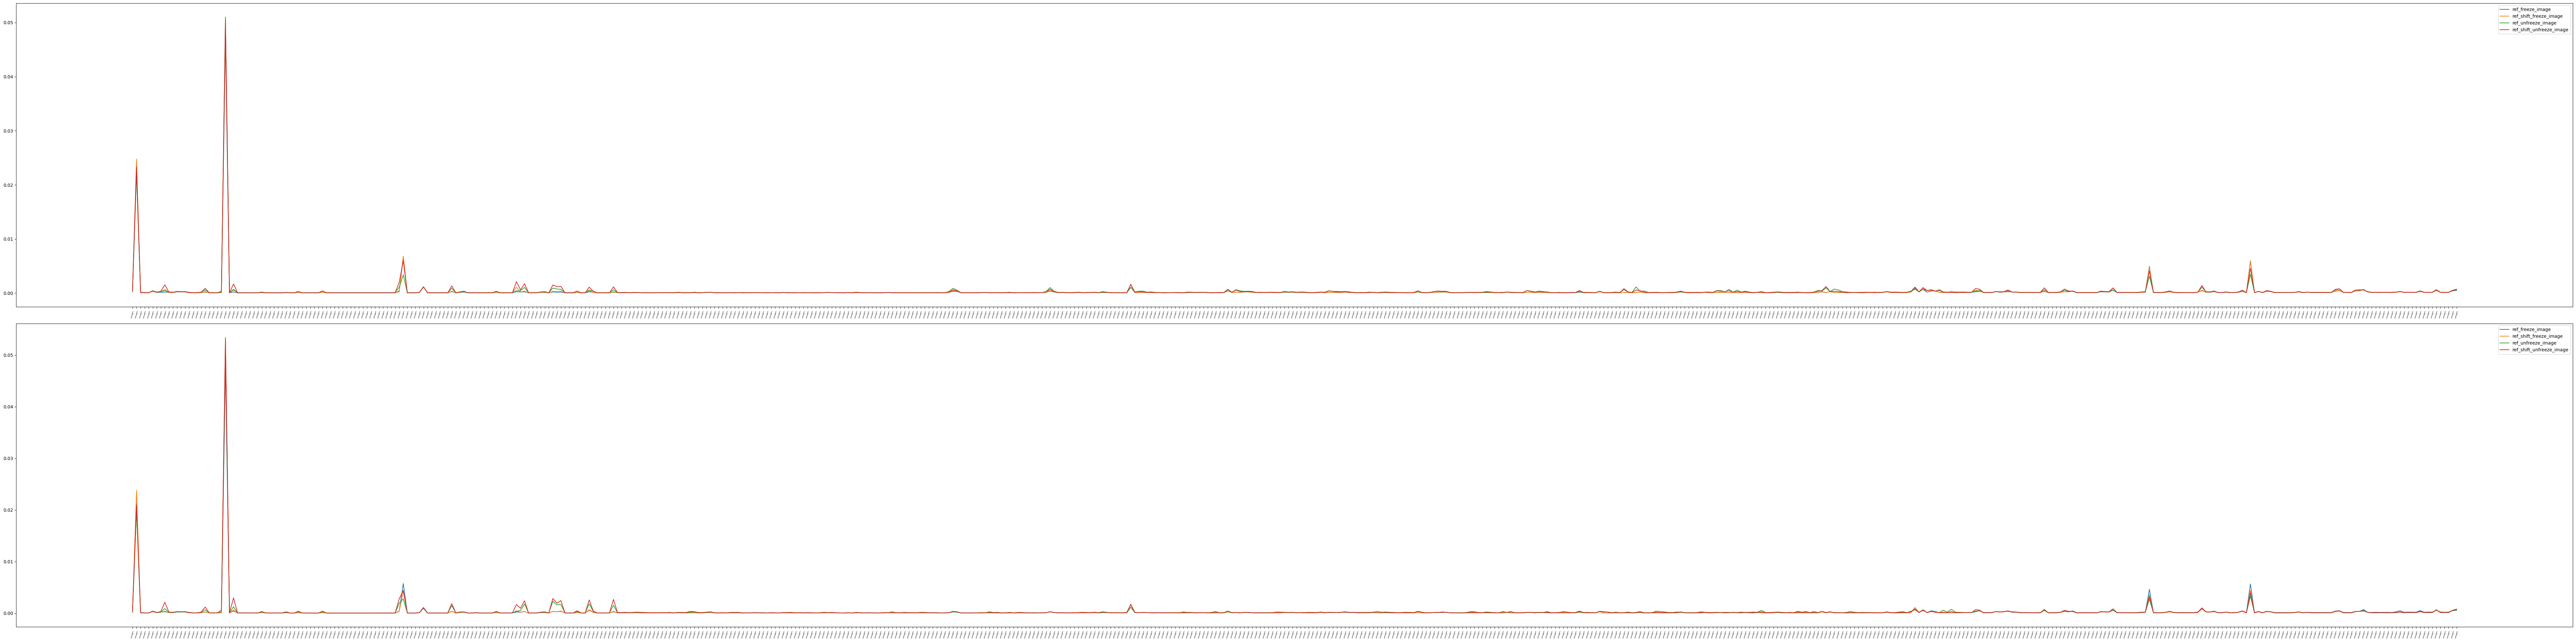

In [7]:
image_index = freeze_projector_attn['image_index']
decode_images_token = decode_labels[image_index:image_index+576]


fig, ax = plt.subplots(len(ref_indices),1,figsize=(80, 20))

for i,ref_index in enumerate(ref_indices):
    ref_attn_matrix = llm_attn_matrix_freeze_mean[ref_index,:][image_index:image_index+576]
    ref_attn_matrix_shift = llm_attn_matrix_freeze_mean[ref_indices_shift[i],:][image_index:image_index+576]
    ref_attn_matrix_unfreeze = llm_attn_matrix_unfreeze_mean[ref_index,:][image_index:image_index+576]
    ref_attn_matrix_unfreeze_shift = llm_attn_matrix_unfreeze_mean[ref_indices_shift[i],:][image_index:image_index+576]


    ax[i].plot(ref_attn_matrix,label='ref_freeze_image')
    ax[i].plot(ref_attn_matrix_shift,label='ref_shift_freeze_image')
    ax[i].plot(ref_attn_matrix_unfreeze,label='ref_unfreeze_image')
    ax[i].plot(ref_attn_matrix_unfreeze_shift,label='ref_shift_unfreeze_image')
    ax[i].set_xticks(range(len(ref_attn_matrix)))
    ax[i].legend()
    ax[i].set_xticklabels(decode_images_token,rotation=75, fontsize=4)
    # ax[i].set_title("at each token, the sum of attention weights over all the vision tokens")
    
# 显示图像
plt.tight_layout()
plt.show()

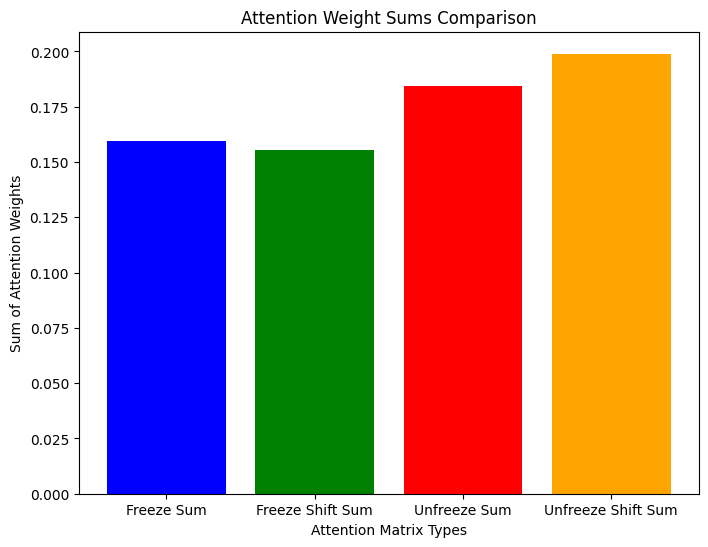

In [8]:
# ref token to attention weight sum

ref_freeze_sum = llm_attn_matrix_freeze_mean[ref_index,:][image_index:image_index+576].sum()
ref_attn_matrix_shift_sum = llm_attn_matrix_freeze_mean[ref_indices_shift[i],:][image_index:image_index+576].sum()
ref_attn_matrix_unfreeze_sum = llm_attn_matrix_unfreeze_mean[ref_index,:][image_index:image_index+576].sum()
ref_attn_matrix_unfreeze_shift_sum = llm_attn_matrix_unfreeze_mean[ref_indices_shift[i],:][image_index:image_index+576].sum()


# Labels for the bars
labels = ['Freeze Sum', 'Freeze Shift Sum', 'Unfreeze Sum', 'Unfreeze Shift Sum']

# Values for each bar
values = [ref_freeze_sum, ref_attn_matrix_shift_sum, ref_attn_matrix_unfreeze_sum, ref_attn_matrix_unfreeze_shift_sum]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'green', 'red', 'orange'])

# Add titles and labels
plt.title('Attention Weight Sums Comparison')
plt.xlabel('Attention Matrix Types')
plt.ylabel('Sum of Attention Weights')

# Show the plot
plt.show()

## Show the influnce of instruction & prompt

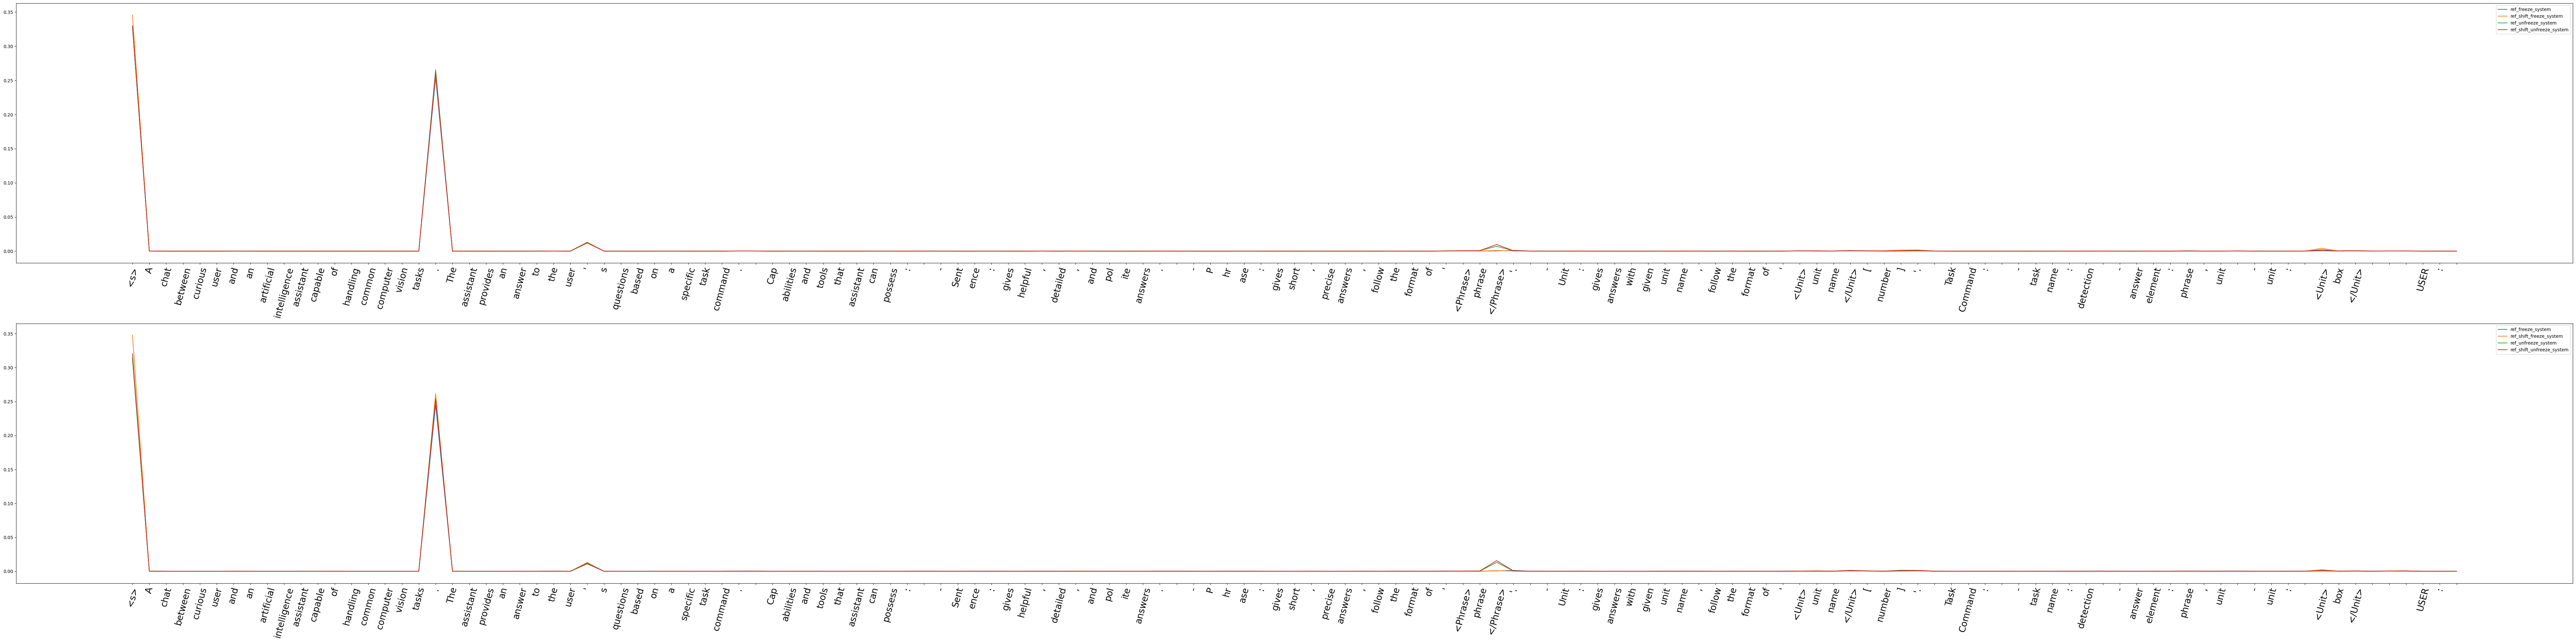

In [9]:
# instruction

image_index = freeze_projector_attn['image_index']
decode_images_token = decode_labels[:image_index]


fig, ax = plt.subplots(len(ref_indices),1,figsize=(80, 20))

for i,ref_index in enumerate(ref_indices):
    ref_attn_matrix = llm_attn_matrix_freeze_mean[ref_index,:][:image_index]
    ref_attn_matrix_shift = llm_attn_matrix_freeze_mean[ref_indices_shift[i],:][:image_index]
    ref_attn_matrix_unfreeze = llm_attn_matrix_unfreeze_mean[ref_index,:][:image_index]
    ref_attn_matrix_unfreeze_shift = llm_attn_matrix_unfreeze_mean[ref_indices_shift[i],:][:image_index]


    ax[i].plot(ref_attn_matrix,label='ref_freeze_system')
    ax[i].plot(ref_attn_matrix_shift,label='ref_shift_freeze_system')
    ax[i].plot(ref_attn_matrix_unfreeze,label='ref_unfreeze_system')
    ax[i].plot(ref_attn_matrix_unfreeze_shift,label='ref_shift_unfreeze_system')
    ax[i].set_xticks(range(len(ref_attn_matrix)))
    ax[i].legend()
    ax[i].set_xticklabels(decode_images_token,rotation=75, fontsize=20)
    # ax[i].set_title("at each token, the sum of attention weights over all the vision tokens")
    
# 显示图像
plt.tight_layout()
plt.show()

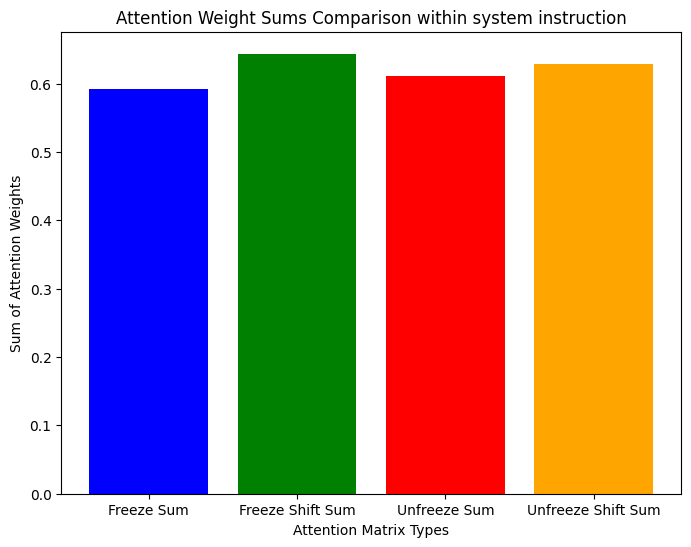

In [10]:
# ref token to attention weight sum

ref_freeze_sum = llm_attn_matrix_freeze_mean[ref_index,:][:image_index].sum()
ref_attn_matrix_shift_sum = llm_attn_matrix_freeze_mean[ref_indices_shift[i],:][:image_index].sum()
ref_attn_matrix_unfreeze_sum = llm_attn_matrix_unfreeze_mean[ref_index,:][:image_index].sum()
ref_attn_matrix_unfreeze_shift_sum = llm_attn_matrix_unfreeze_mean[ref_indices_shift[i],:][:image_index].sum()


# Labels for the bars
labels = ['Freeze Sum', 'Freeze Shift Sum', 'Unfreeze Sum', 'Unfreeze Shift Sum']

# Values for each bar
values = [ref_freeze_sum, ref_attn_matrix_shift_sum, ref_attn_matrix_unfreeze_sum, ref_attn_matrix_unfreeze_shift_sum]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'green', 'red', 'orange'])

# Add titles and labels
plt.title('Attention Weight Sums Comparison within system instruction')
plt.xlabel('Attention Matrix Types')
plt.ylabel('Sum of Attention Weights')

# Show the plot
plt.show()

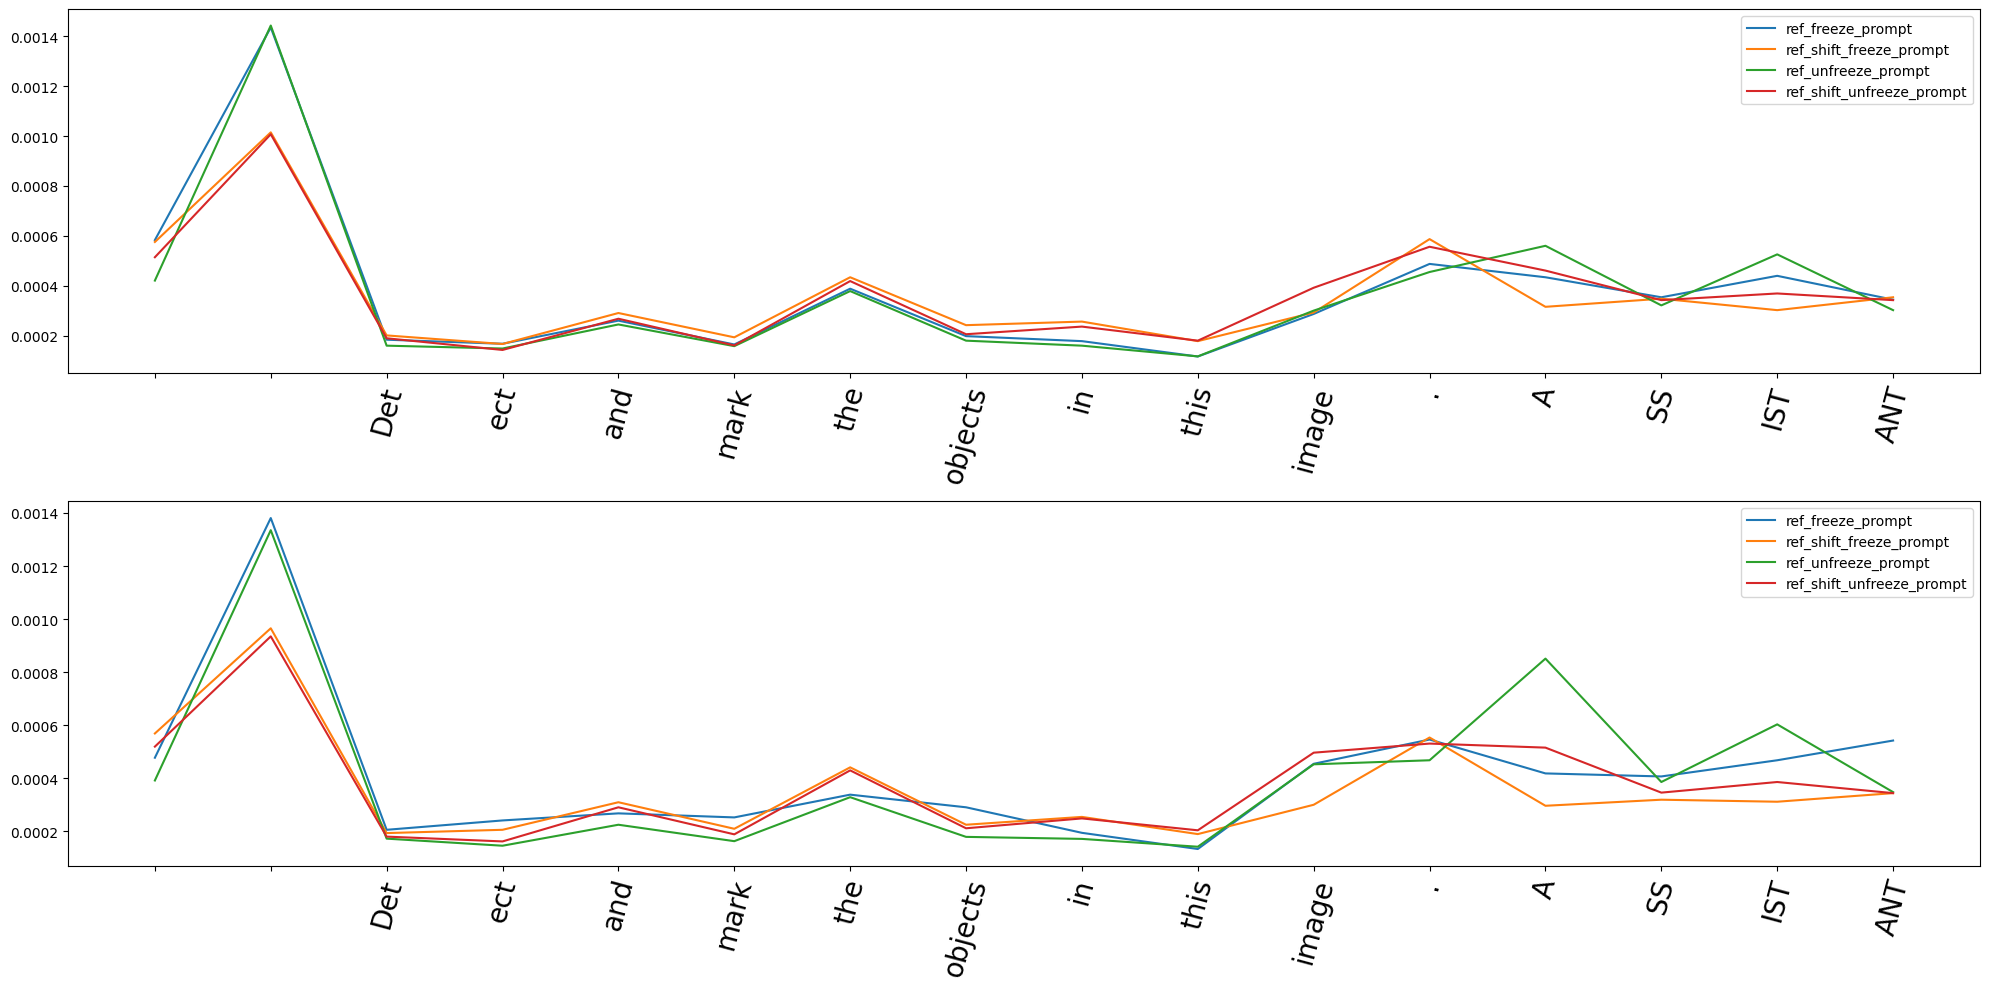

In [11]:
decode_labels_prompt = decode_labels[image_index+576:image_index+576+16]

fig, ax = plt.subplots(len(ref_indices),1,figsize=(20, 10))

for i,ref_index in enumerate(ref_indices):
    ref_attn_matrix = llm_attn_matrix_freeze_mean[ref_index,:][image_index+576:image_index+576+16]
    ref_attn_matrix_shift = llm_attn_matrix_freeze_mean[ref_indices_shift[i],:][image_index+576:image_index+576+16]
    ref_attn_matrix_unfreeze = llm_attn_matrix_unfreeze_mean[ref_index,:][image_index+576:image_index+576+16]
    ref_attn_matrix_unfreeze_shift = llm_attn_matrix_unfreeze_mean[ref_indices_shift[i],:][image_index+576:image_index+576+16]


    ax[i].plot(ref_attn_matrix,label='ref_freeze_prompt')
    ax[i].plot(ref_attn_matrix_shift,label='ref_shift_freeze_prompt')
    ax[i].plot(ref_attn_matrix_unfreeze,label='ref_unfreeze_prompt')
    ax[i].plot(ref_attn_matrix_unfreeze_shift,label='ref_shift_unfreeze_prompt')
    ax[i].set_xticks(range(len(ref_attn_matrix)))
    ax[i].legend()
    ax[i].set_xticklabels(decode_labels_prompt,rotation=75, fontsize=20)
    # ax[i].set_title("at each token, the sum of attention weights over all the vision tokens")
    
# 显示图像
plt.tight_layout()
plt.show()

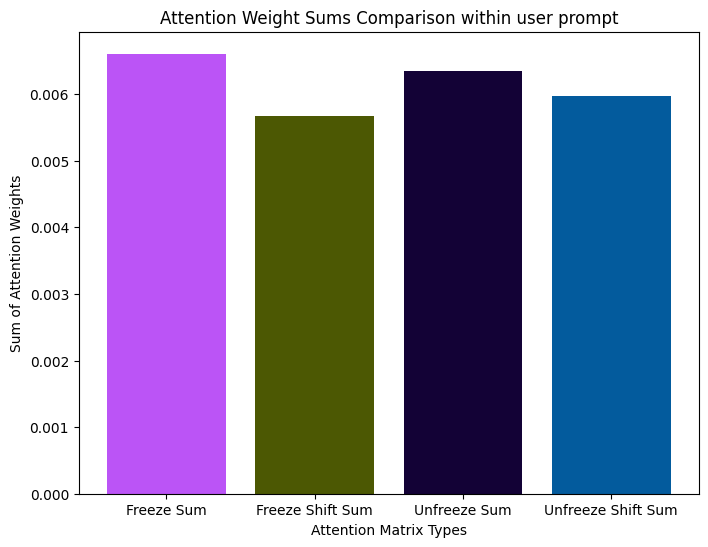

In [12]:
# ref token to attention weight sum

ref_freeze_sum = llm_attn_matrix_freeze_mean[ref_index,:][image_index+576:image_index+576+16].sum()
ref_attn_matrix_shift_sum = llm_attn_matrix_freeze_mean[ref_indices_shift[i],:][image_index+576:image_index+576+16].sum()
ref_attn_matrix_unfreeze_sum = llm_attn_matrix_unfreeze_mean[ref_index,:][image_index+576:image_index+576+16].sum()
ref_attn_matrix_unfreeze_shift_sum = llm_attn_matrix_unfreeze_mean[ref_indices_shift[i],:][image_index+576:image_index+576+16].sum()


# Labels for the bars
labels = ['Freeze Sum', 'Freeze Shift Sum', 'Unfreeze Sum', 'Unfreeze Shift Sum']
random_colors = np.random.rand(4, 3)

# Values for each bar
values = [ref_freeze_sum, ref_attn_matrix_shift_sum, ref_attn_matrix_unfreeze_sum, ref_attn_matrix_unfreeze_shift_sum]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=random_colors)

# Add titles and labels
plt.title('Attention Weight Sums Comparison within user prompt')
plt.xlabel('Attention Matrix Types')
plt.ylabel('Sum of Attention Weights')

# Show the plot
plt.show()

## Output tokens

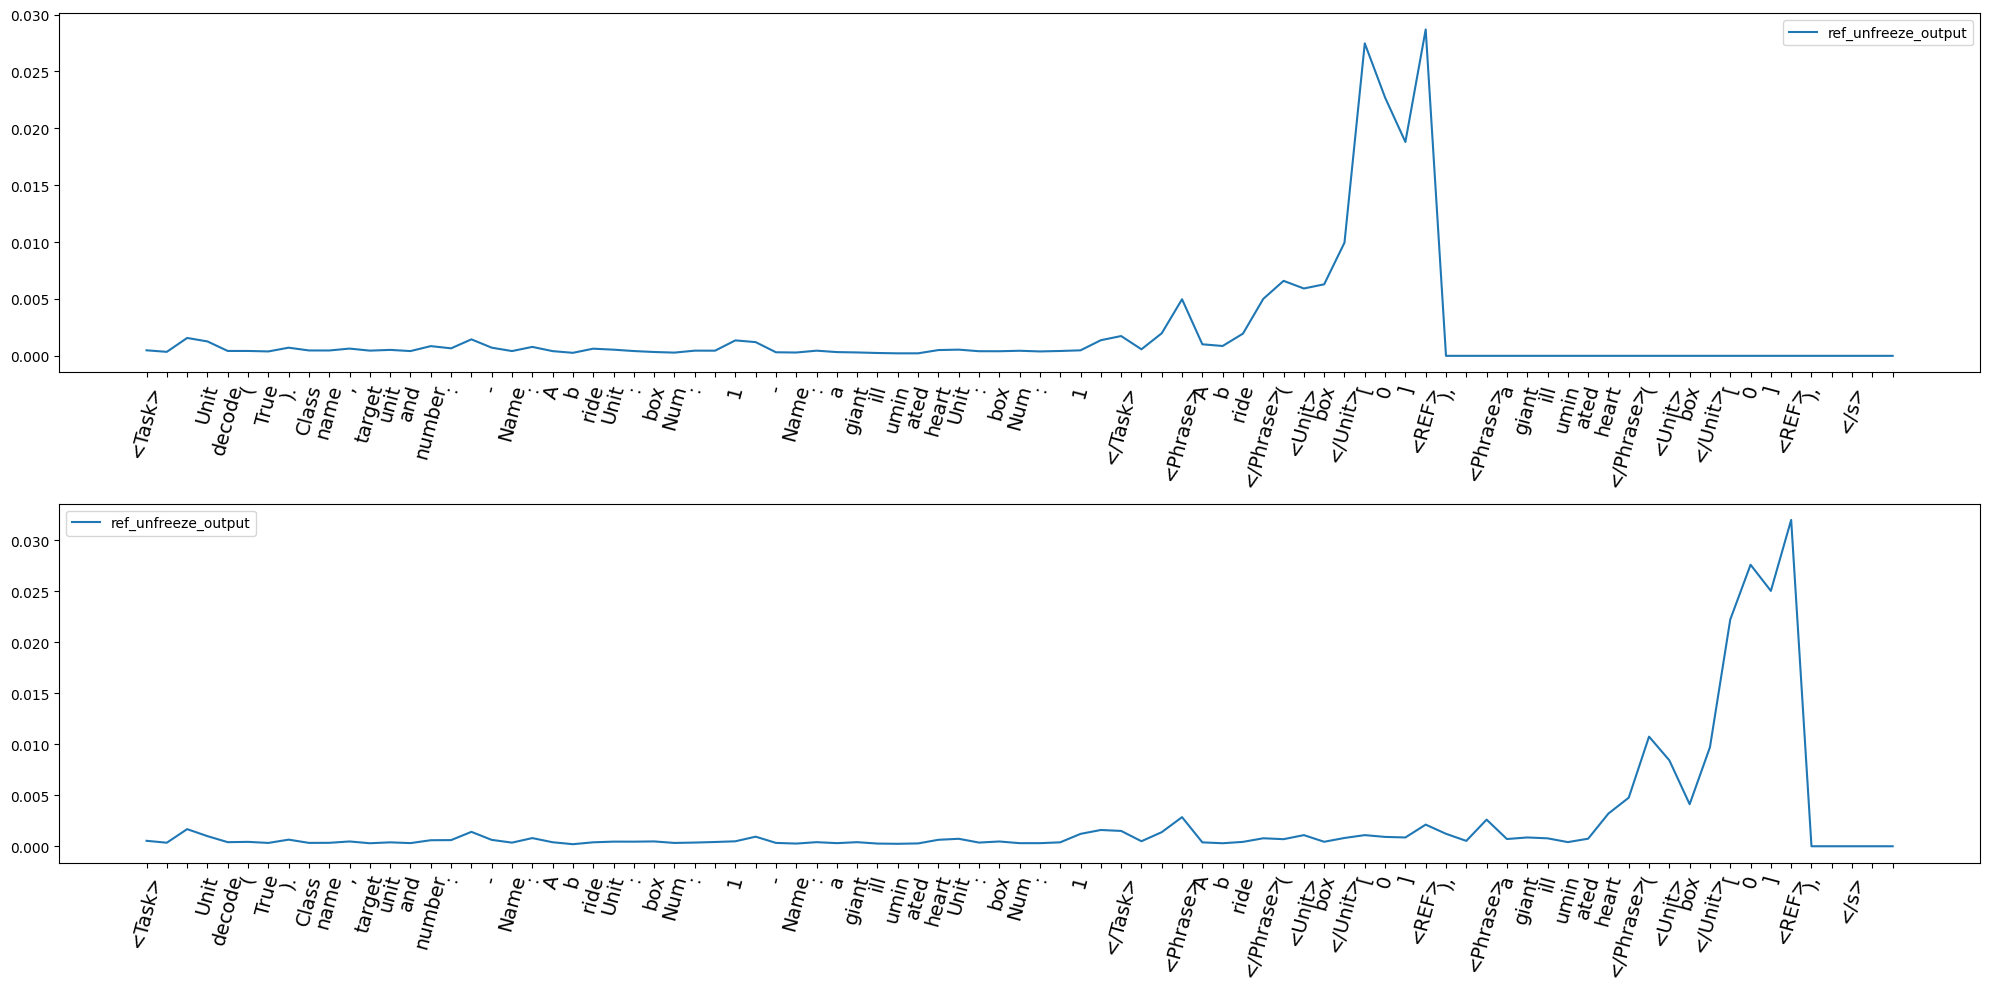

In [18]:
decode_labels_output = decode_labels[image_index+576+17:]

fig, ax = plt.subplots(len(ref_indices),1,figsize=(20, 10))

ref_attn_matrix_unfreeze_list = []

for i,ref_index in enumerate(ref_indices):
    # ref_attn_matrix = llm_attn_matrix_freeze_mean[ref_index,:][image_index+576+17:]
    # ref_attn_matrix_shift = llm_attn_matrix_freeze_mean[ref_indices_shift[i],:][image_index+576+17:]
    ref_attn_matrix_unfreeze = llm_attn_matrix_unfreeze_mean[ref_index,:][image_index+576+17:]
    # ref_attn_matrix_unfreeze_shift = llm_attn_matrix_unfreeze_mean[ref_indices_shift[i],:][image_index+576+17:]


    # ax[i].plot(ref_attn_matrix,label='ref_freeze_output')
    # ax[i].plot(ref_attn_matrix_shift,label='ref_shift_freeze_output')
    ax[i].plot(ref_attn_matrix_unfreeze,label='ref_unfreeze_output')
    # ax[i].plot(ref_attn_matrix_unfreeze_shift,label='ref_shift_unfreeze_output')
    ax[i].set_xticks(range(len(ref_attn_matrix)))
    ax[i].legend()
    ax[i].set_xticklabels(decode_labels_output,rotation=75, fontsize=14)
    # ax[i].set_title("at each token, the sum of attention weights over all the vision tokens")
    
# 显示图像
plt.tight_layout()
plt.show()

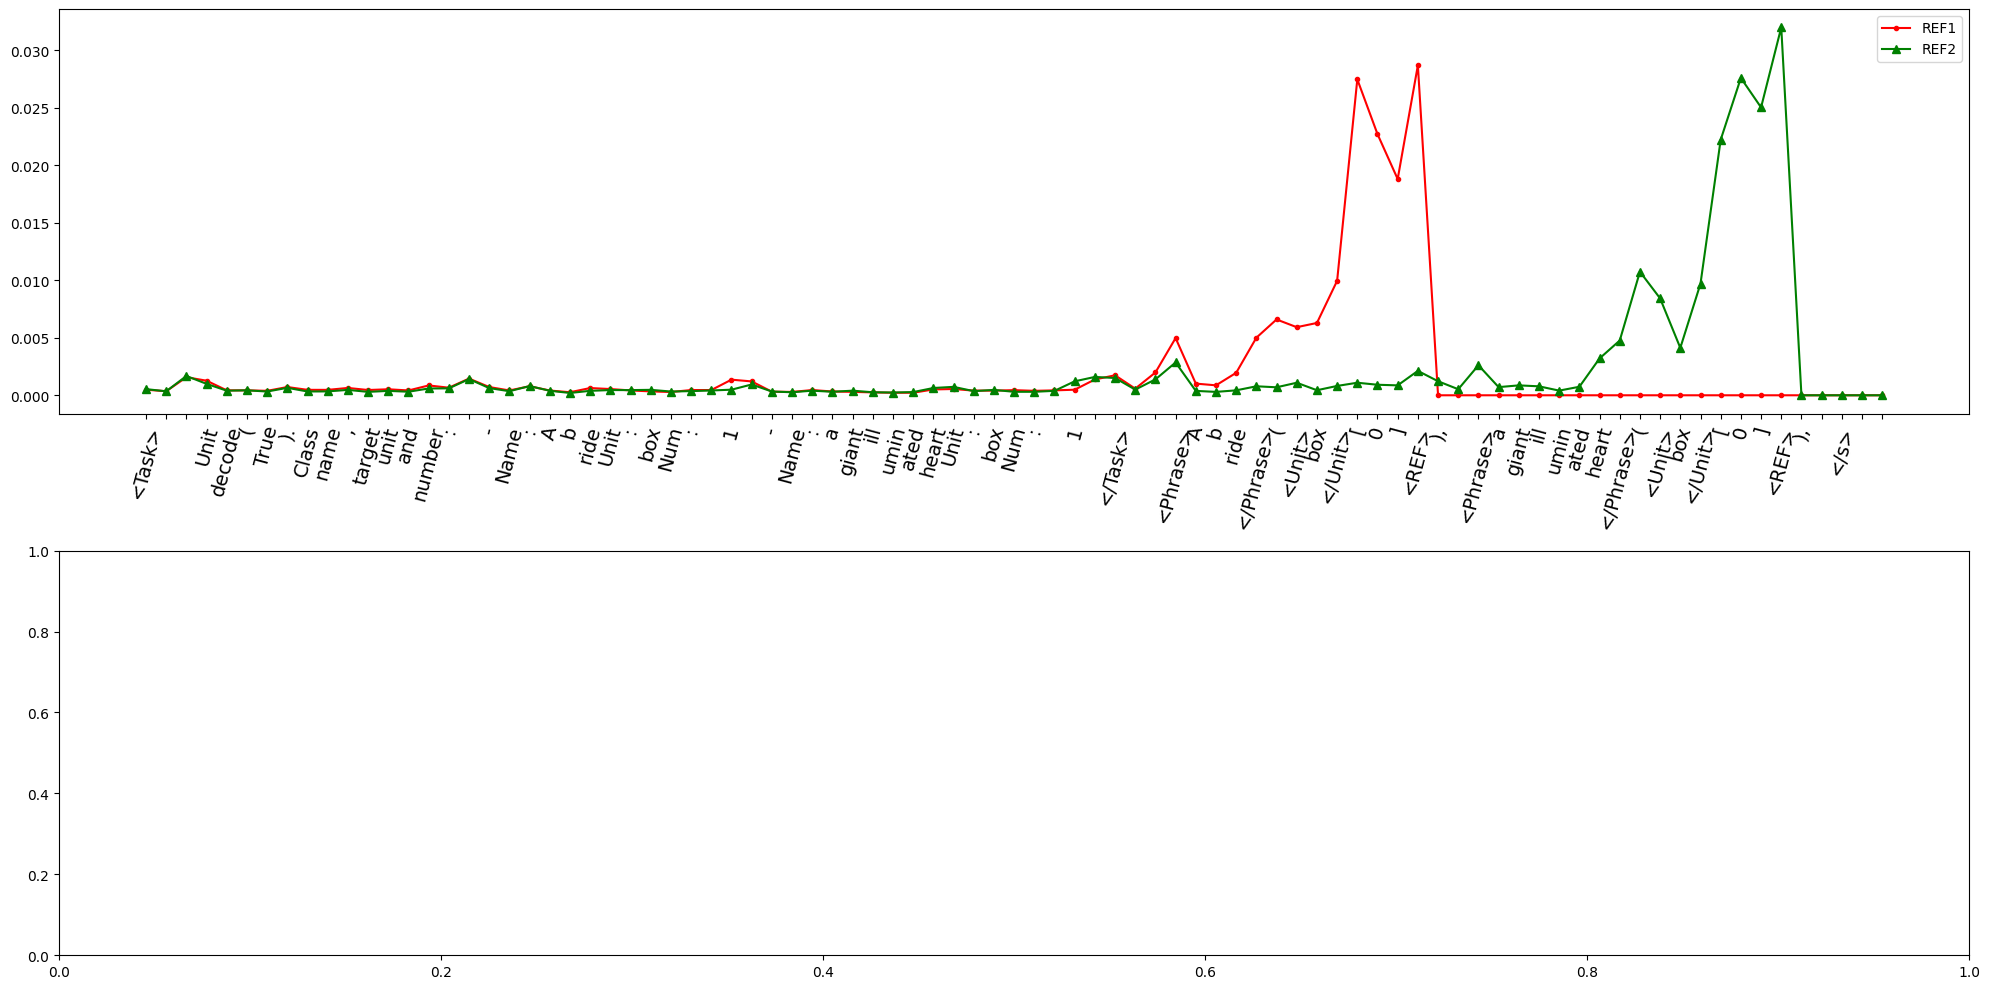

In [34]:
decode_labels_output = decode_labels[image_index+576+17:]


fig, ax = plt.subplots(len(ref_indices),1,figsize=(20, 10))
ref_attn_matrix_unfreeze_list = []

for i,ref_index in enumerate(ref_indices):
    # ref_attn_matrix = llm_attn_matrix_freeze_mean[ref_index,:][image_index+576+17:]
    # ref_attn_matrix_shift = llm_attn_matrix_freeze_mean[ref_indices_shift[i],:][image_index+576+17:]
    ref_attn_matrix_unfreeze = llm_attn_matrix_unfreeze_mean[ref_index,:][image_index+576+17:]
    # ref_attn_matrix_unfreeze_shift = llm_attn_matrix_unfreeze_mean[ref_indices_shift[i],:][image_index+576+17:]
    ref_attn_matrix_unfreeze_list.append(ref_attn_matrix_unfreeze)


ax[0].plot(ref_attn_matrix_unfreeze_list[0],'r.-',label='REF1')
ax[0].plot(ref_attn_matrix_unfreeze_list[1],'g^-',label='REF2')
# ax[i].plot(ref_attn_matrix_unfreeze_shift,label='ref_shift_unfreeze_output')
ax[0].set_xticks(range(len(ref_attn_matrix)))
ax[0].legend()
# ax[0].grid()
ax[0].set_xticklabels(decode_labels_output,rotation=75, fontsize=14)
# ax[i].set_title("at each token, the sum of attention weights over all the vision tokens")
    
# 显示图像
plt.tight_layout()
plt.show()

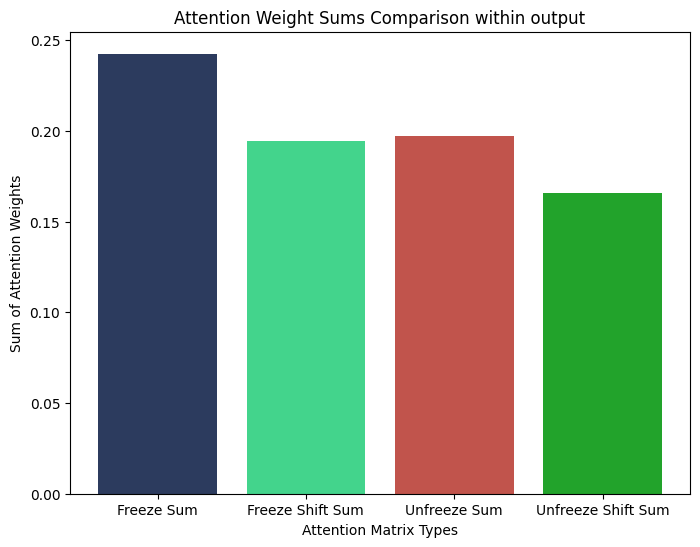

In [14]:
# ref token to attention weight sum

ref_freeze_sum = llm_attn_matrix_freeze_mean[ref_index,:][image_index+576+17:].sum()
ref_attn_matrix_shift_sum = llm_attn_matrix_freeze_mean[ref_indices_shift[i],:][image_index+576+17:].sum()
ref_attn_matrix_unfreeze_sum = llm_attn_matrix_unfreeze_mean[ref_index,:][image_index+576+17:].sum()
ref_attn_matrix_unfreeze_shift_sum = llm_attn_matrix_unfreeze_mean[ref_indices_shift[i],:][image_index+576+17:].sum()


# Labels for the bars
labels = ['Freeze Sum', 'Freeze Shift Sum', 'Unfreeze Sum', 'Unfreeze Shift Sum']
random_colors = np.random.rand(4, 3)

# Values for each bar
values = [ref_freeze_sum, ref_attn_matrix_shift_sum, ref_attn_matrix_unfreeze_sum, ref_attn_matrix_unfreeze_shift_sum]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=random_colors)

# Add titles and labels
plt.title('Attention Weight Sums Comparison within output')
plt.xlabel('Attention Matrix Types')
plt.ylabel('Sum of Attention Weights')

# Show the plot
plt.show()

## Calculate the sum of each layer with REF of visual tokens

In [48]:
attn_each_layer_freeze = freeze_projector_attn['attention'].mean(dim=2)[:,0,:,:]
attn_each_layer_unfreeze = unfreeze_attn['attention'].mean(dim=2)[:,0,:,:]

In [49]:
decode_labels = freeze_projector_attn['decode_labels']
ref_indices = freeze_projector_attn['ref_indices']
ref_indices_shift = ref_indices - 1
ref_indices = ref_indices.tolist()
ref_indices_shift = ref_indices_shift.tolist()

In [59]:
ref_attn_matrix_freeze_sum = attn_each_layer_freeze[:,ref_index,:][:,image_index:image_index+576].sum(dim=-1).cpu().float().numpy().tolist()
ref_attn_matrix_freeze_shift_sum = attn_each_layer_freeze[:,ref_indices_shift[i],:][:,image_index:image_index+576].sum(dim=-1).cpu().float().numpy().tolist()
ref_attn_matrix_unfreeze_sum = attn_each_layer_unfreeze[:,ref_index,:][:,image_index:image_index+576].sum(dim=-1).cpu().float().numpy().tolist()
ref_attn_matrix_unfreeze_shift_sum = attn_each_layer_unfreeze[:,ref_indices_shift[i],:][:,image_index:image_index+576].sum(dim=-1).cpu().float().numpy().tolist()

In [61]:
print(attn_each_layer_freeze[:,ref_index,:][:,image_index:image_index+576].sum(dim=-1).sum())
print(attn_each_layer_unfreeze[:,ref_index,:][:,image_index:image_index+576].sum(dim=-1).sum())

tensor(5.0938, dtype=torch.bfloat16)
tensor(5.9062, dtype=torch.bfloat16)


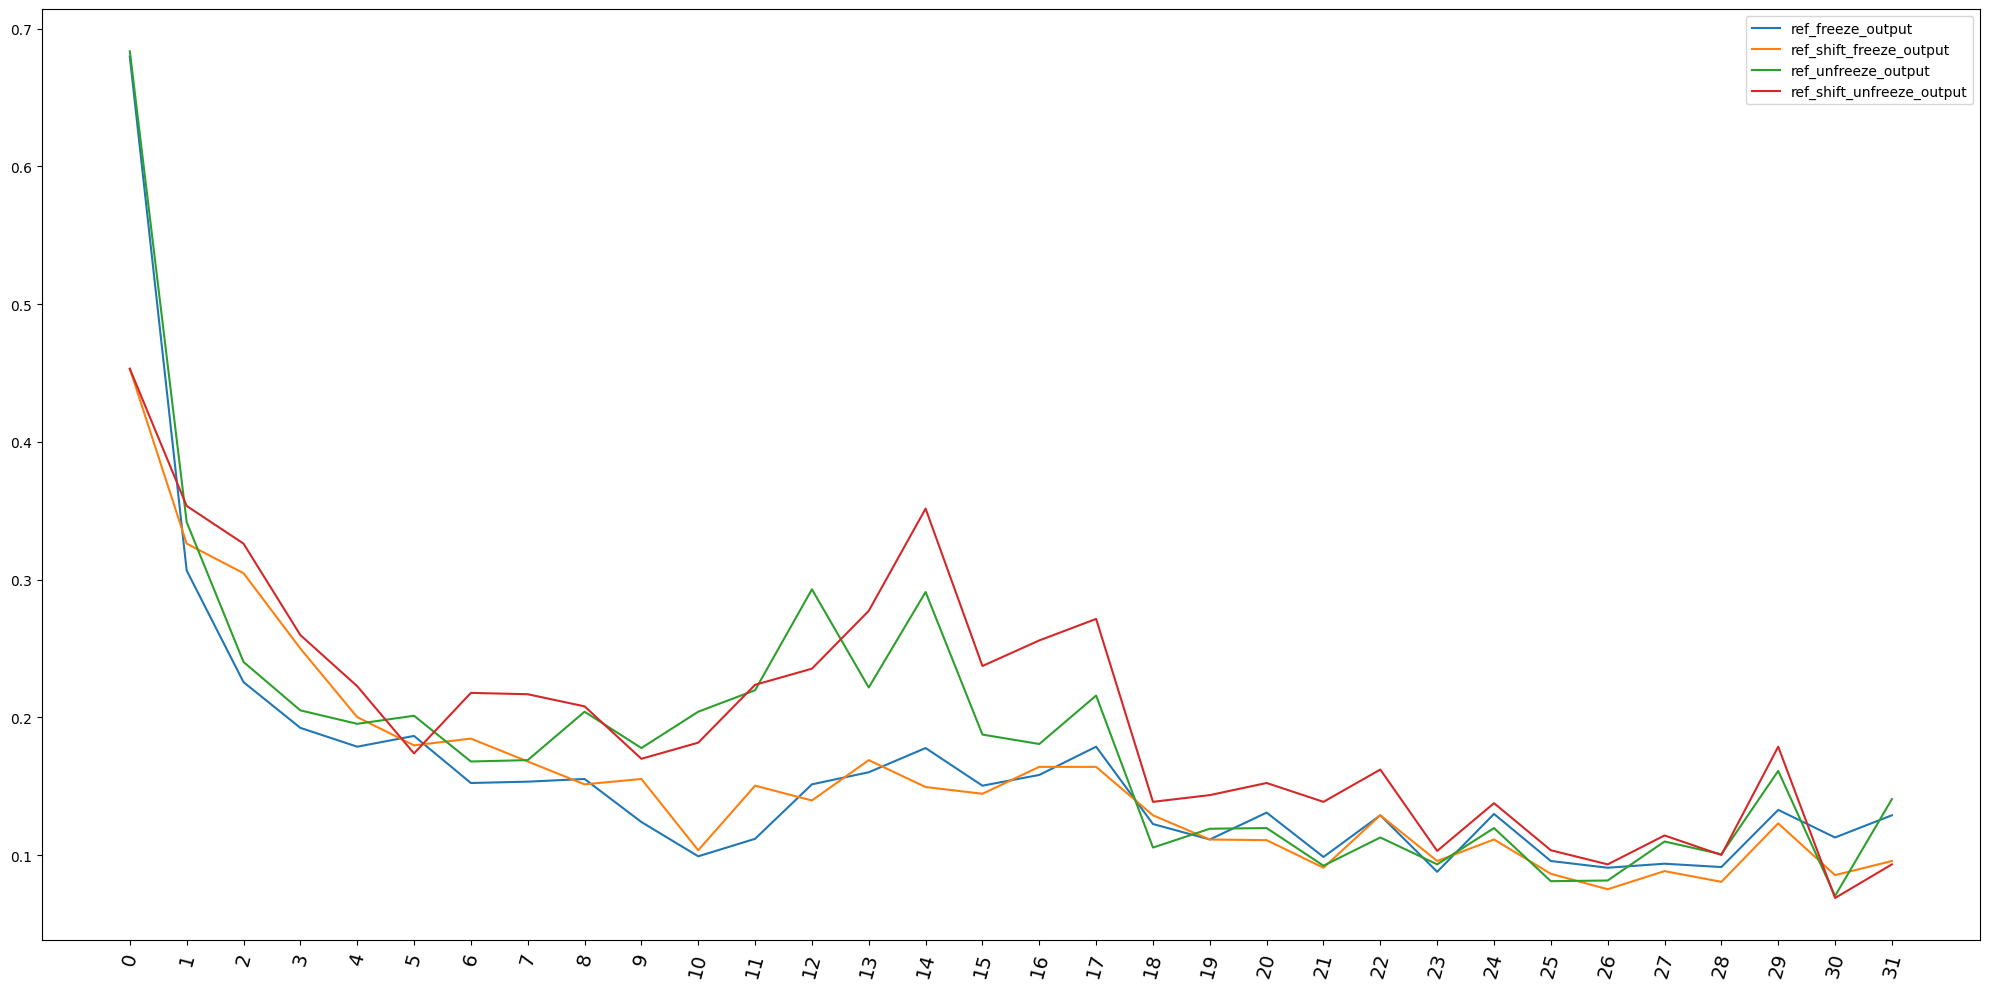

In [62]:
decode_labels_output = range(len(ref_attn_matrix_freeze_sum))

fig, ax = plt.subplots(1,1,figsize=(20, 10))

ax.plot(ref_attn_matrix_freeze_sum,label='ref_freeze_output')
ax.plot(ref_attn_matrix_freeze_shift_sum,label='ref_shift_freeze_output')
ax.plot(ref_attn_matrix_unfreeze_sum,label='ref_unfreeze_output')
ax.plot(ref_attn_matrix_unfreeze_shift_sum,label='ref_shift_unfreeze_output')
ax.set_xticks(range(len(ref_attn_matrix_freeze_sum)))
ax.legend()
ax.set_xticklabels(decode_labels_output,rotation=75, fontsize=14)
# ax[i].set_title("at each token, the sum of attention weights over all the vision tokens")

# 显示图像
plt.tight_layout()
plt.show()